
# No Smoke Max Fall Isopleth with Photon Flux

This notebook loads the No Smoke Max Fall dataset, enriches each sample with photon flux data from the Synoptic/MesoWest API (station `QHW` – Hawthorne), and renders an ozone isopleth with data points colored by how far their photon flux deviates from the seasonal mean.


In [16]:
import os
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from scipy.interpolate import LSQBivariateSpline

plt.style.use('seaborn-v0_8')
sns.set_context('talk')
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

MESOWEST_TOKEN = os.getenv("MESOWEST_TOKEN")
if not MESOWEST_TOKEN:
    raise ValueError('Please set the MESOWEST_TOKEN environment variable before running this notebook.')

STATION_ID = 'QHW'  # Hawthorne

In [17]:
data_path = Path('../data/utah/nosmoke/No_Smoke_Max_Fall.csv')
no_smoke_df = pd.read_csv(data_path, parse_dates=['dt'])
no_smoke_df.sort_values('dt', inplace=True)
no_smoke_df['dt_hour'] = no_smoke_df['dt'].dt.floor('H')

print(f"Loaded {len(no_smoke_df)} observations spanning {no_smoke_df['dt'].min()} to {no_smoke_df['dt'].max()}.")
no_smoke_df.head()

Loaded 162 observations spanning 2021-09-01 15:00:00 to 2023-09-30 10:00:00.


,NOx,VOC,Ozone,dt,dt_hour
0,4.3,14.1395,80.0,2021-09-01 15:00:00,2021-09-01 15:00:00
1,5.2,27.2669,58.0,2021-09-10 16:00:00,2021-09-10 16:00:00
2,3.2,21.5934,63.0,2021-09-25 15:00:00,2021-09-25 15:00:00
3,3.3,28.0155,64.0,2021-09-26 14:00:00,2021-09-26 14:00:00
4,4.2,27.8623,41.0,2021-09-28 17:00:00,2021-09-28 17:00:00


In [18]:
TIMEZONE = 'America/Denver'
BASE_URL = 'https://api.synopticdata.com/v2/stations/timeseries'


def fetch_synoptic_series(token: str, station: str, start, end, variable: str = 'solar_radiation', obtimezone: str = 'local') -> pd.Series: # I could not find any other solar radiation type variable this seems to only work for solar radiation not the uv stuff
    """Fetch hourly observations for a Synoptic/MesoWest station."""
    params = {
        'token': token,
        'stid': station,
        'start': start.strftime('%Y%m%d%H%M'),
        'end': end.strftime('%Y%m%d%H%M'),
        'vars': variable,
        'obtimezone': obtimezone,
        'output': 'json'
    }
    response = requests.get(BASE_URL, params=params, timeout=30)
    response.raise_for_status()
    payload = response.json()
    summary = payload.get('SUMMARY', {})
    if summary.get('RESPONSE_CODE') != 1 or not payload.get('STATION'):
        raise RuntimeError(f"Synoptic request failed: {summary.get('RESPONSE_MESSAGE')}")

    observations = payload['STATION'][0]['OBSERVATIONS']
    timestamps = pd.to_datetime(observations['date_time'], utc=True)
    local_index = timestamps.tz_convert(TIMEZONE).tz_localize(None)
    values = pd.Series(observations[f'{variable}_set_1'], index=local_index, dtype='float64')
    return values.rename(variable)

In [19]:
start = no_smoke_df['dt'].min() - timedelta(days=1)
end = no_smoke_df['dt'].max() + timedelta(days=1)

solar_radiation = fetch_synoptic_series(MESOWEST_TOKEN, STATION_ID, start, end, variable='solar_radiation')
solar_radiation.index = solar_radiation.index.floor('H') #They give hourly rates.
solar_radiation = solar_radiation.rename('solar_radiation_w_m2')

merged_df = no_smoke_df.merge(solar_radiation, left_on='dt_hour', right_index=True, how='left')
missing_radiation = merged_df['solar_radiation_w_m2'].isna().sum()
if missing_radiation:
    print(f'[INFO] {missing_radiation} samples are missing solar radiation data; consider tightening the Synoptic query window.')

radiation_mean = merged_df['solar_radiation_w_m2'].mean()
merged_df['solar_radiation_delta'] = merged_df['solar_radiation_w_m2'] - radiation_mean

merged_df.drop(columns=['dt_hour'], inplace=True)
merged_df.head()


[INFO] 1 samples are missing solar radiation data; consider tightening the Synoptic query window.


,NOx,VOC,Ozone,dt,solar_radiation_w_m2,solar_radiation_delta
0,4.3,14.1395,80.0,2021-09-01 15:00:00,530.0,86.310559
1,5.2,27.2669,58.0,2021-09-10 16:00:00,320.0,-123.689441
2,3.2,21.5934,63.0,2021-09-25 15:00:00,720.0,276.310559
3,3.3,28.0155,64.0,2021-09-26 14:00:00,702.0,258.310559
4,4.2,27.8623,41.0,2021-09-28 17:00:00,440.0,-3.689441


In [20]:
summary_cols = ['solar_radiation_w_m2', 'solar_radiation_delta']
summary_stats = merged_df[summary_cols].agg(['mean', 'std', 'min', 'max']).T
summary_stats


,mean,std,min,max
solar_radiation_w_m2,4.436894e+02,213.333519,0.000000,798.000000
solar_radiation_delta,-1.412259e-15,213.333519,-443.689441,354.310559


[INFO] Knots: [ 61.8228 117.8584], [35.8]


/var/folders/8y/j4zbl6y95zn4hrbsnlzpz6yc0000gn/T/ipykernel_15659/3967300413.py:12: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=8). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  spline = LSQBivariateSpline(x, y, z, knot_x, knot_y, eps=2.002002002101761e-12)


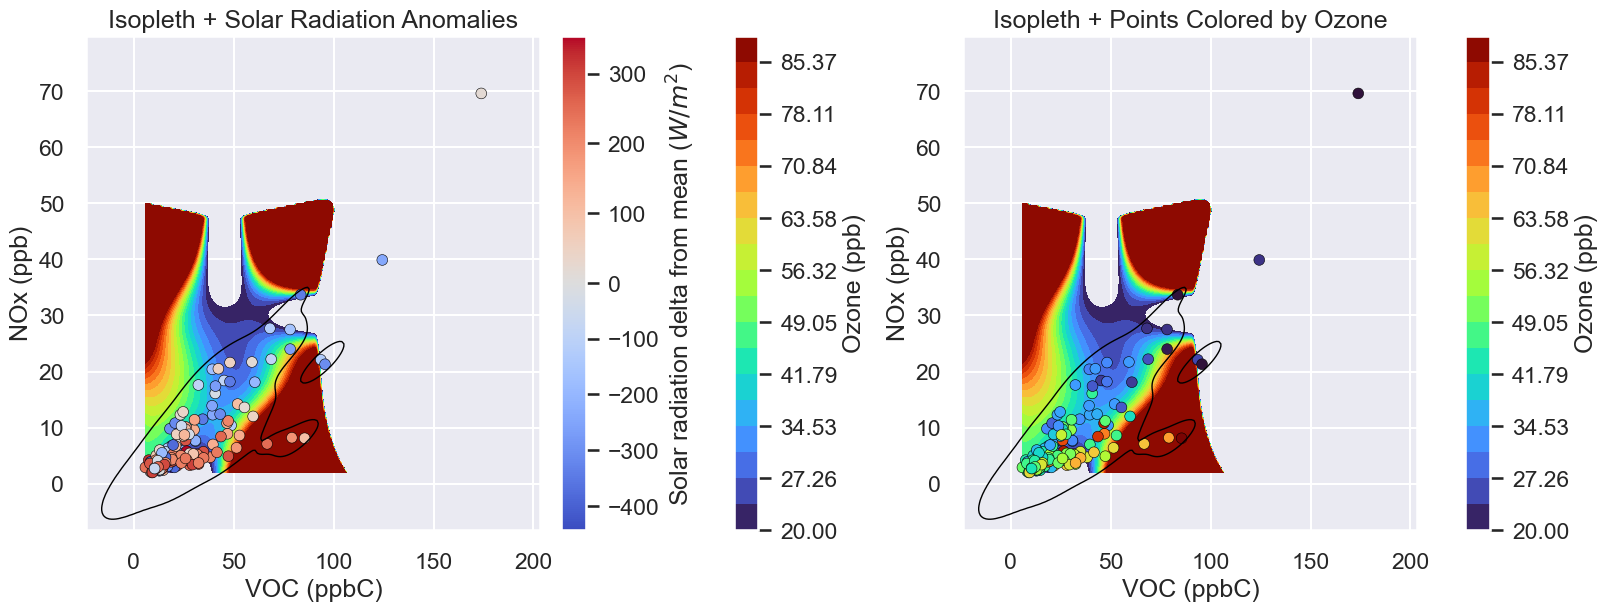

In [21]:
def plot_isopleth_with_radiation(data: pd.DataFrame) -> None:
    x = data['VOC'].astype(float)
    y = data['NOx'].astype(float)
    z = data['Ozone'].astype(float)
    delta = data['solar_radiation_delta'].astype(float)

    knot_x = np.linspace(x.min(), x.max(), 4)[1:-1]
    knot_y = np.linspace(y.min(), y.max(), 3)[1:-1]

    print(f'[INFO] Knots: {knot_x}, {knot_y}')

    spline = LSQBivariateSpline(x, y, z, knot_x, knot_y, eps=2.002002002101761e-12)

    grid_x = np.linspace(x.min(), x.max(), 200)
    grid_y = np.linspace(y.min(), y.max(), 200)
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = spline(grid_x, grid_y)
    ozone_max = z.max()
    ozone_min = z.min()
    # Limit the spline output so it never exceeds the observed max ozone
    Z = np.clip(Z, None, ozone_max)
    # Use levels based on observed data range to avoid plotting beyond data
    contour_levels = np.linspace(ozone_min, ozone_max, 20)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    # LEFT: scatter colored by solar radiation delta
    contour0 = axes[0].contourf(X, Y, Z, levels=contour_levels, cmap='turbo')
    fig.colorbar(contour0, ax=axes[0], pad=0.08, label='Ozone (ppb)')

    norm_delta = TwoSlopeNorm(vmin=delta.min(), vcenter=0, vmax=delta.max())
    scatter0 = axes[0].scatter(
        x, y, c=delta, cmap='coolwarm', norm=norm_delta,
        edgecolor='black', linewidth=0.4, s=60
    )
    fig.colorbar(scatter0, ax=axes[0], pad=0.02,
                 label='Solar radiation delta from mean ($W/m^2$)')

    sns.kdeplot(data=data, x='VOC', y='NOx', ax=axes[0], levels=2,
                color='black', linewidths=1.0, fill=False)

    axes[0].set_xlabel('VOC (ppbC)')
    axes[0].set_ylabel('NOx (ppb)')
    axes[0].set_title('Isopleth + Solar Radiation Anomalies')

    # RIGHT: scatter colored by ozone values
    contour1 = axes[1].contourf(X, Y, Z, levels=contour_levels, cmap='turbo')
    scatter1 = axes[1].scatter(
        x, y, c=z, cmap='turbo', vmin=ozone_min, vmax=ozone_max,
        edgecolor='black', linewidth=0.4, s=60
    )
    fig.colorbar(contour1, ax=axes[1], pad=0.08, label='Ozone (ppb)')

    sns.kdeplot(data=data, x='VOC', y='NOx', ax=axes[1], levels=2,
                color='black', linewidths=1.0, fill=False)

    axes[1].set_xlabel('VOC (ppbC)')
    axes[1].set_ylabel('NOx (ppb)')
    axes[1].set_title('Isopleth + Points Colored by Ozone')

    plt.show()

plot_isopleth_with_radiation(merged_df.dropna(subset=['solar_radiation_delta']))


## 5 ppb VOC/NOx binned distributions

Segment the merged dataset into 5 ppb by 5 ppb VOC/NOx bins and summarize the median ozone and solar radiation in each cell. Bins with fewer than three samples are hidden to avoid noisy estimates, and counts for qualifying bins are overlaid on the ozone panel. Additional plots characterize the distribution of ozone and solar radiation within each occupied bin and compare ozone to solar radiation for each cell.

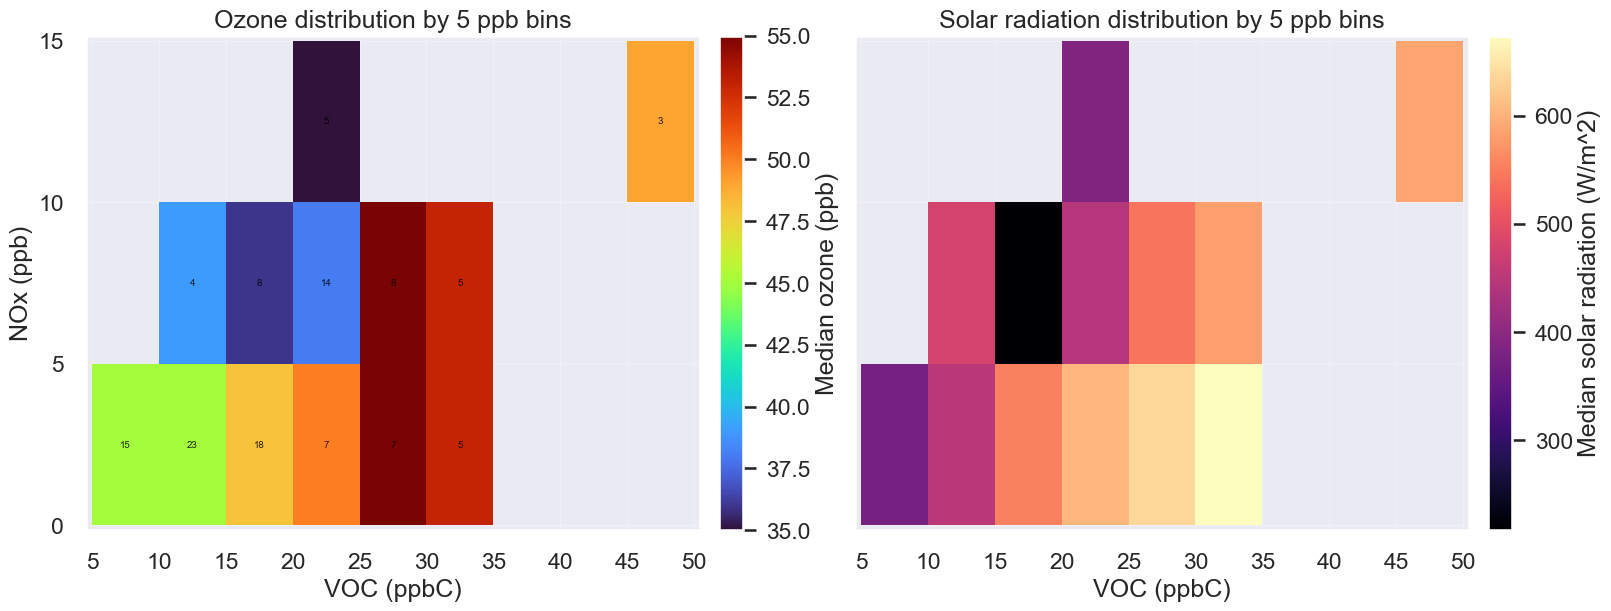

[INFO] Bins meeting count threshold: 13 / 27
[INFO] Bins with at least one sample: 22 / 27
[INFO] Total samples represented: 134


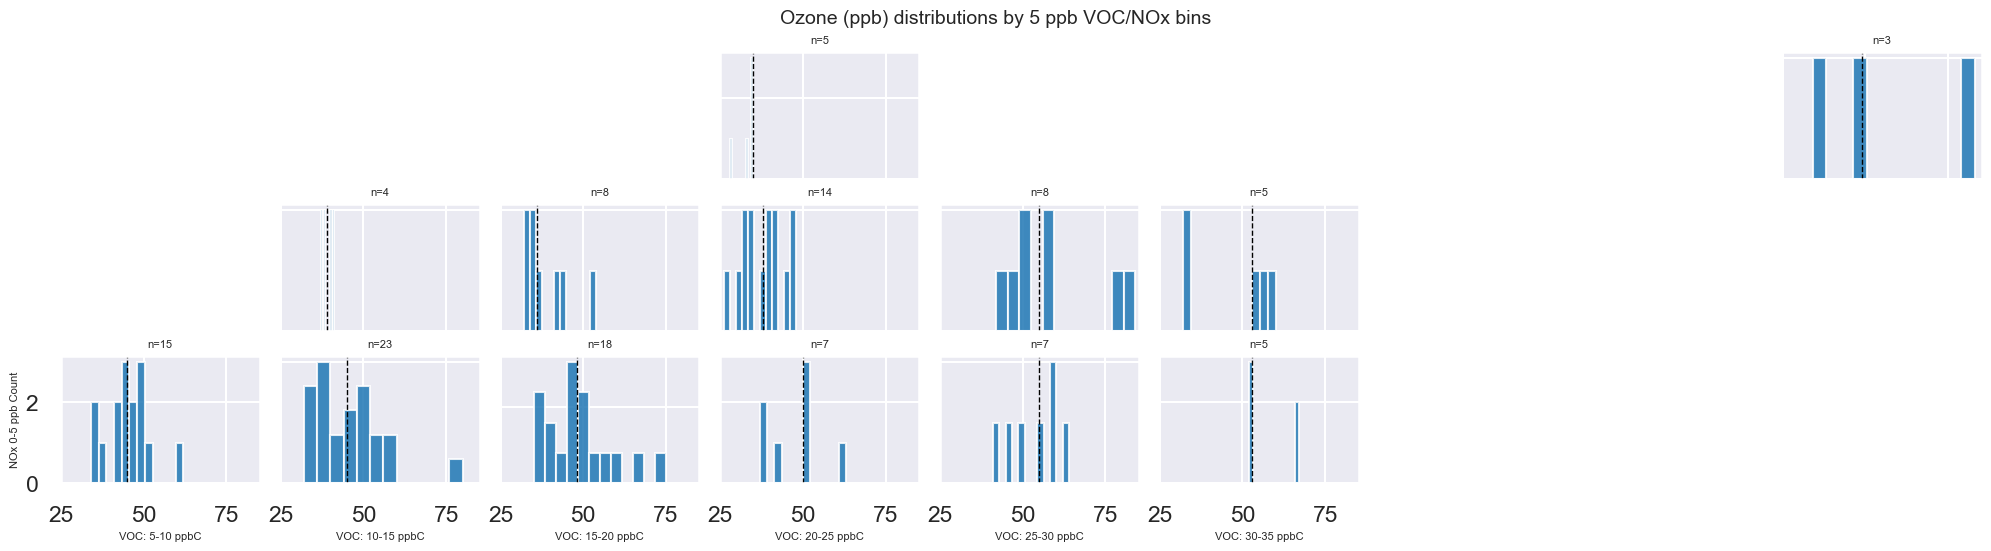

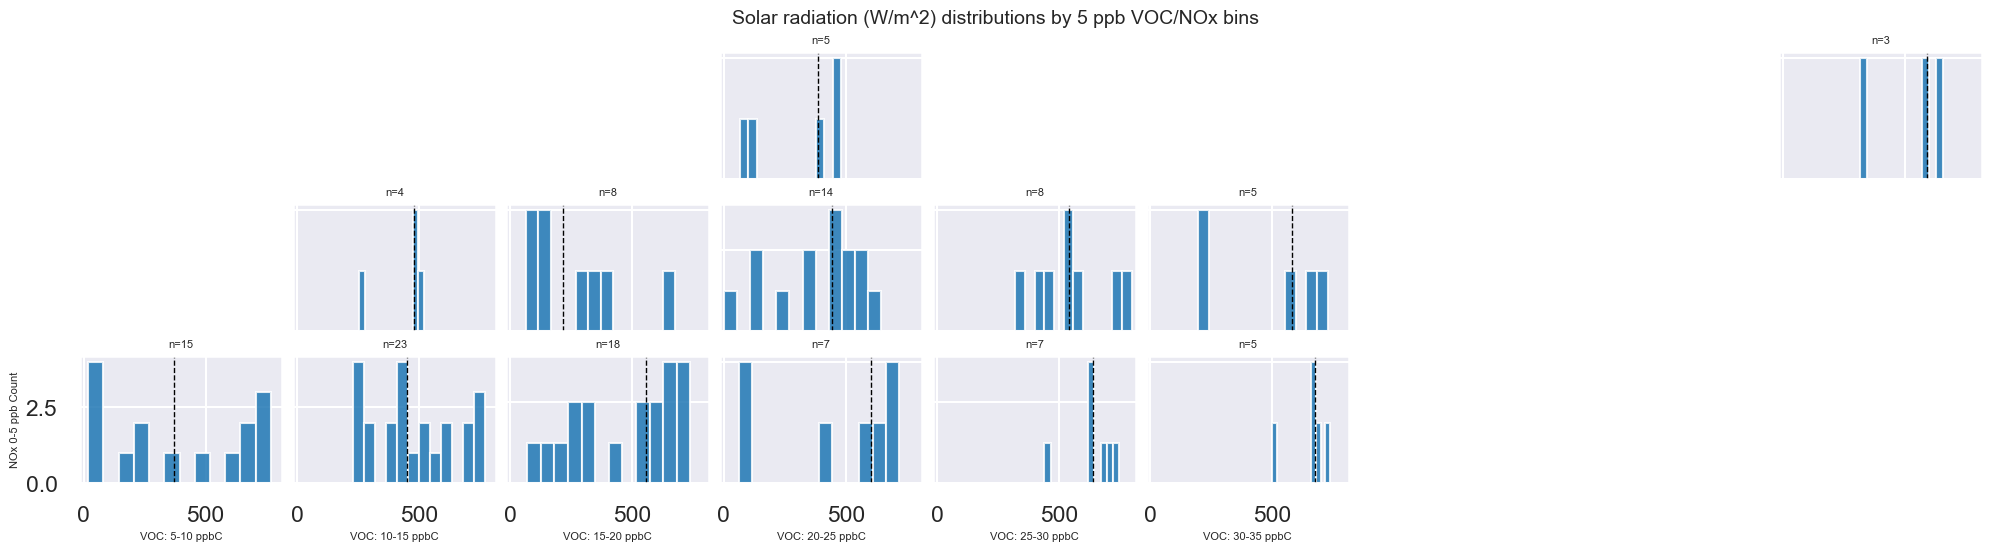

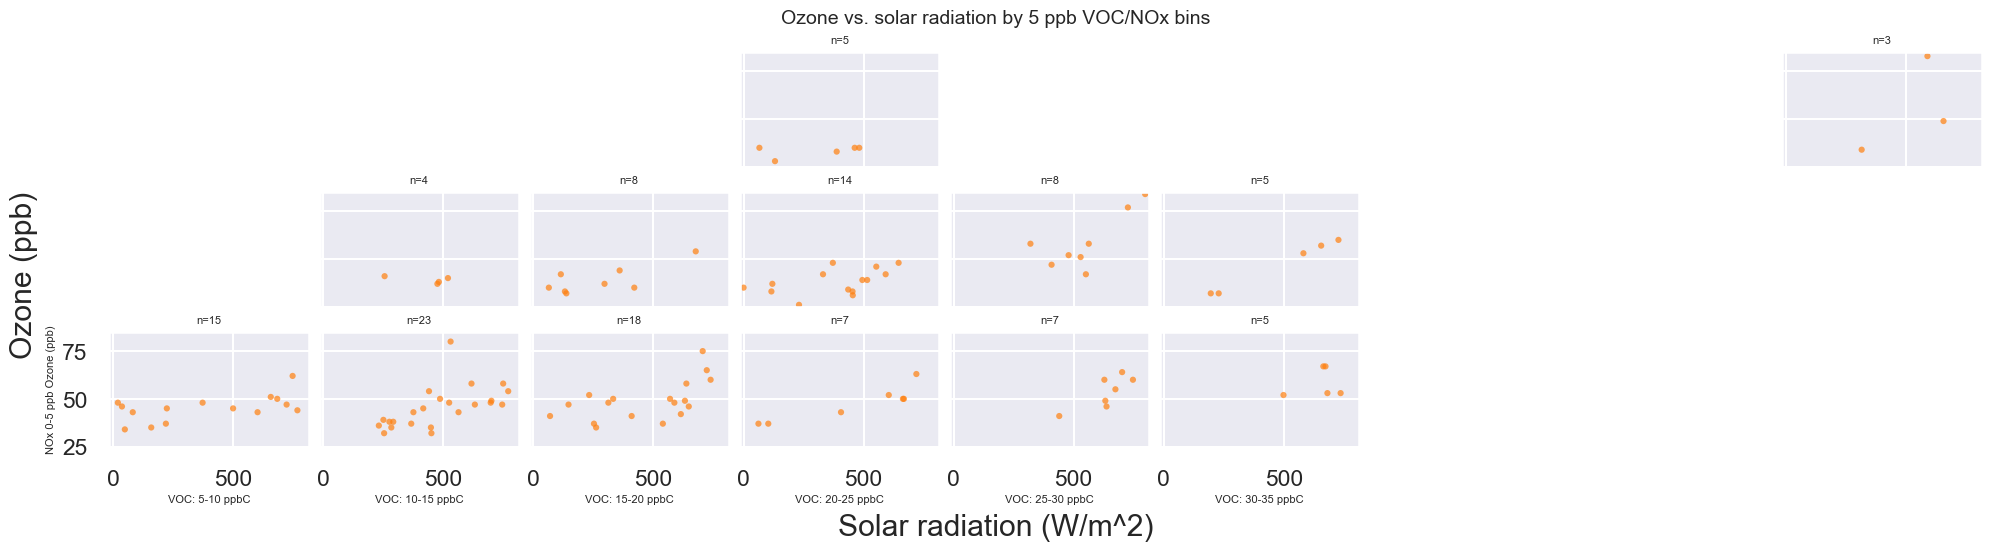

In [27]:

    BIN_WIDTH = 5.0
    MIN_COUNT = 3


    def _expand_limits(vmin: float, vmax: float, frac: float = 0.02):
        if np.isclose(vmin, vmax):
            width = abs(vmin) * frac or 1.0
            return vmin - width, vmax + width
        span = vmax - vmin
        pad = span * frac
        return vmin - pad, vmax + pad


    def prepare_binned_data(data: pd.DataFrame, bin_width: float = BIN_WIDTH) -> dict:
        required_cols = ['VOC', 'NOx', 'Ozone', 'solar_radiation_w_m2']
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Data missing required columns: {missing_cols}")

        filtered = data.dropna(subset=required_cols).copy()
        if filtered.empty:
            raise ValueError('No rows with complete data for the required columns.')

        def make_edges(series: pd.Series) -> np.ndarray:
            start = np.floor(series.min() / bin_width) * bin_width
            stop = np.ceil(series.max() / bin_width) * bin_width
            if start == stop:
                stop += bin_width
            return np.arange(start, stop + bin_width, bin_width)

        voc_edges = make_edges(filtered['VOC'])
        nox_edges = make_edges(filtered['NOx'])

        filtered['VOC_bin'] = pd.cut(filtered['VOC'], bins=voc_edges, include_lowest=True, right=False)
        filtered['NOx_bin'] = pd.cut(filtered['NOx'], bins=nox_edges, include_lowest=True, right=False)

        voc_index = pd.IntervalIndex.from_breaks(voc_edges, closed='left')
        nox_index = pd.IntervalIndex.from_breaks(nox_edges, closed='left')

        binned = filtered.dropna(subset=['VOC_bin', 'NOx_bin'])

        ozone_grid = (
            binned.pivot_table(index='NOx_bin', columns='VOC_bin', values='Ozone', aggfunc='median')
            .reindex(index=nox_index, columns=voc_index)
        )
        radiation_grid = (
            binned.pivot_table(index='NOx_bin', columns='VOC_bin', values='solar_radiation_w_m2', aggfunc='median')
            .reindex(index=nox_index, columns=voc_index)
        )
        count_grid = (
            binned.pivot_table(index='NOx_bin', columns='VOC_bin', values='Ozone', aggfunc='count')
            .reindex(index=nox_index, columns=voc_index)
            .fillna(0)
        )

        return {
            'filtered': filtered,
            'binned': binned,
            'voc_edges': voc_edges,
            'nox_edges': nox_edges,
            'voc_index': voc_index,
            'nox_index': nox_index,
            'ozone_grid': ozone_grid,
            'radiation_grid': radiation_grid,
            'counts': count_grid,
            'voc_min': filtered['VOC'].min(),
            'voc_max': filtered['VOC'].max(),
            'nox_min': filtered['NOx'].min(),
            'nox_max': filtered['NOx'].max(),
            'ozone_min': filtered['Ozone'].min(),
            'ozone_max': filtered['Ozone'].max(),
            'radiation_min': filtered['solar_radiation_w_m2'].min(),
            'radiation_max': filtered['solar_radiation_w_m2'].max(),
        }


    def plot_binned_distributions(data: pd.DataFrame, bin_width: float = BIN_WIDTH, min_count: int = MIN_COUNT) -> dict:
        summary = prepare_binned_data(data, bin_width=bin_width)

        ozone_grid = summary['ozone_grid']
        radiation_grid = summary['radiation_grid']
        count_grid = summary['counts']

        if min_count:
            occupancy_mask = count_grid >= min_count
        else:
            occupancy_mask = pd.DataFrame(True, index=count_grid.index, columns=count_grid.columns)

        if occupancy_mask.any().any():
            row_flags = occupancy_mask.any(axis=1).to_numpy()
            col_flags = occupancy_mask.any(axis=0).to_numpy()
            row_indices = np.flatnonzero(row_flags)
            col_indices = np.flatnonzero(col_flags)
        else:
            row_indices = np.arange(count_grid.shape[0])
            col_indices = np.arange(count_grid.shape[1])

        if row_indices.size == 0 or col_indices.size == 0:
            row_indices = np.arange(count_grid.shape[0])
            col_indices = np.arange(count_grid.shape[1])

        r0, r1 = row_indices[0], row_indices[-1]
        c0, c1 = col_indices[0], col_indices[-1]

        trimmed_ozone = ozone_grid.iloc[r0:r1 + 1, c0:c1 + 1]
        trimmed_radiation = radiation_grid.iloc[r0:r1 + 1, c0:c1 + 1]
        trimmed_counts = count_grid.iloc[r0:r1 + 1, c0:c1 + 1]
        trimmed_mask = occupancy_mask.iloc[r0:r1 + 1, c0:c1 + 1]

        if min_count:
            trimmed_ozone = trimmed_ozone.where(trimmed_mask)
            trimmed_radiation = trimmed_radiation.where(trimmed_mask)

        voc_edges = np.asarray(summary['voc_edges'], dtype=float)
        nox_edges = np.asarray(summary['nox_edges'], dtype=float)
        trimmed_voc_edges = voc_edges[c0:c1 + 2]
        trimmed_nox_edges = nox_edges[r0:r1 + 2]

        plot_voc_min, plot_voc_max = _expand_limits(trimmed_voc_edges[0], trimmed_voc_edges[-1], frac=0.01)
        plot_nox_min, plot_nox_max = _expand_limits(trimmed_nox_edges[0], trimmed_nox_edges[-1], frac=0.01)

        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True, constrained_layout=True)

        mesh0 = axes[0].pcolormesh(trimmed_voc_edges, trimmed_nox_edges, trimmed_ozone.to_numpy(), shading='auto', cmap='turbo')
        fig.colorbar(mesh0, ax=axes[0], pad=0.02, label='Median ozone (ppb)')
        axes[0].set_title(f'Ozone distribution by {bin_width:.0f} ppb bins')
        axes[0].set_xlabel('VOC (ppbC)')
        axes[0].set_ylabel('NOx (ppb)')

        mesh1 = axes[1].pcolormesh(trimmed_voc_edges, trimmed_nox_edges, trimmed_radiation.to_numpy(), shading='auto', cmap='magma')
        fig.colorbar(mesh1, ax=axes[1], pad=0.02, label='Median solar radiation (W/m^2)')
        axes[1].set_title(f'Solar radiation distribution by {bin_width:.0f} ppb bins')
        axes[1].set_xlabel('VOC (ppbC)')

        for ax in axes:
            ax.set_xlim(plot_voc_min, plot_voc_max)
            ax.set_ylim(plot_nox_min, plot_nox_max)
            ax.set_xticks(trimmed_voc_edges)
            ax.set_yticks(trimmed_nox_edges)
            ax.set_axisbelow(True)
            ax.grid(which='major', color='white', linewidth=0.4, alpha=0.6)

        if len(trimmed_voc_edges) > 12:
            for ax in axes:
                ax.tick_params(axis='x', rotation=90)

        voc_centers = (trimmed_voc_edges[:-1] + trimmed_voc_edges[1:]) / 2
        nox_centers = (trimmed_nox_edges[:-1] + trimmed_nox_edges[1:]) / 2
        counts_array = trimmed_counts.to_numpy()
        mask_array = trimmed_mask.to_numpy()

        for row_idx, y_center in enumerate(nox_centers):
            for col_idx, x_center in enumerate(voc_centers):
                if mask_array[row_idx, col_idx]:
                    axes[0].text(x_center, y_center, f"{int(counts_array[row_idx, col_idx])}",
                                 ha='center', va='center', fontsize=7, color='black', alpha=0.85)

        plt.show()

        active_voc_bins = trimmed_ozone.columns
        active_nox_bins = trimmed_ozone.index
        active_filtered = summary['filtered'][
            summary['filtered']['VOC_bin'].isin(active_voc_bins)
            & summary['filtered']['NOx_bin'].isin(active_nox_bins)
        ]

        summary.update({
            'active_voc_bins': active_voc_bins,
            'active_nox_bins': active_nox_bins,
            'active_voc_edges': trimmed_voc_edges,
            'active_nox_edges': trimmed_nox_edges,
            'active_counts': trimmed_counts,
            'active_mask': trimmed_mask,
            'active_filtered': active_filtered,
            'active_ozone_grid': trimmed_ozone,
            'active_radiation_grid': trimmed_radiation,
        })

        return summary


    def plot_cell_distributions(summary: dict, variable: str, bins: int = 10, min_count: int = MIN_COUNT) -> None:
        label_map = {
            'Ozone': 'Ozone (ppb)',
            'solar_radiation_w_m2': 'Solar radiation (W/m^2)'
        }
        if variable not in label_map:
            raise ValueError(f'Unsupported variable for distribution plots: {variable}')

        binned = summary.get('active_filtered', summary['binned'])
        voc_bins = list(summary.get('active_voc_bins', summary['voc_index']))
        nox_bins = list(summary.get('active_nox_bins', summary['nox_index']))
        if not voc_bins or not nox_bins:
            raise ValueError('No populated bins available for plotting distributions.')

        count_grid = summary.get('active_counts', summary['counts'])
        if min_count:
            qualifying = (count_grid >= min_count)
        else:
            qualifying = pd.DataFrame(True, index=count_grid.index, columns=count_grid.columns)

        active_binned = binned[
            binned['VOC_bin'].isin(voc_bins) & binned['NOx_bin'].isin(nox_bins)
        ]
        if active_binned.empty:
            raise ValueError('No data available in the populated bins to plot distributions.')

        var_min, var_max = _expand_limits(active_binned[variable].min(), active_binned[variable].max(), frac=0.02)

        ncols = len(voc_bins)
        nrows = len(nox_bins)
        fig_width = max(ncols * 2.2, 6)
        fig_height = max(nrows * 1.8, 4)
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), constrained_layout=True)
        axes = np.atleast_2d(axes)

        nox_order = list(reversed(nox_bins))
        voc_order = list(voc_bins)

        for row_idx, nox_interval in enumerate(nox_order):
            for col_idx, voc_interval in enumerate(voc_order):
                ax = axes[row_idx, col_idx]
                if not qualifying.loc[nox_interval, voc_interval]:
                    ax.set_axis_off()
                    continue

                subset = active_binned[
                    (active_binned['NOx_bin'] == nox_interval)
                    & (active_binned['VOC_bin'] == voc_interval)
                ]
                if subset.empty:
                    ax.set_axis_off()
                    continue

                ax.hist(subset[variable], bins=bins, color='#1f77b4', alpha=0.85)
                median_val = subset[variable].median()
                ax.axvline(median_val, color='black', linestyle='--', linewidth=1)
                ax.set_xlim(var_min, var_max)
                ax.set_title(f"n={len(subset)}", fontsize=8)

                if row_idx == nrows - 1:
                    range_label = f"{voc_interval.left:.0f}-{voc_interval.right:.0f}"
                    ax.set_xlabel(f'VOC: {range_label} ppbC', fontsize=8)
                else:
                    ax.set_xticklabels([])

                if col_idx == 0:
                    range_label = f"{nox_interval.left:.0f}-{nox_interval.right:.0f}"
                    ax.set_ylabel(f'NOx {range_label} ppb Count', fontsize=8)
                else:
                    ax.set_yticklabels([])

        fig.suptitle(f"{label_map[variable]} distributions by {BIN_WIDTH:.0f} ppb VOC/NOx bins", fontsize=14)
        plt.show()


    def plot_cell_ozone_vs_radiation(summary: dict, min_count: int = MIN_COUNT) -> None:
        binned = summary.get('active_filtered', summary['binned'])
        voc_bins = list(summary.get('active_voc_bins', summary['voc_index']))
        nox_bins = list(summary.get('active_nox_bins', summary['nox_index']))
        if not voc_bins or not nox_bins:
            raise ValueError('No populated bins available for plotting ozone vs. radiation.')

        count_grid = summary.get('active_counts', summary['counts'])
        if min_count:
            qualifying = (count_grid >= min_count)
        else:
            qualifying = pd.DataFrame(True, index=count_grid.index, columns=count_grid.columns)

        active_binned = binned[
            binned['VOC_bin'].isin(voc_bins) & binned['NOx_bin'].isin(nox_bins)
        ]
        if active_binned.empty:
            raise ValueError('No data available in the populated bins to plot ozone vs. radiation.')

        rad_min, rad_max = _expand_limits(active_binned['solar_radiation_w_m2'].min(), active_binned['solar_radiation_w_m2'].max(), frac=0.02)
        ozone_min, ozone_max = _expand_limits(active_binned['Ozone'].min(), active_binned['Ozone'].max(), frac=0.02)

        ncols = len(voc_bins)
        nrows = len(nox_bins)
        fig_width = max(ncols * 2.2, 6)
        fig_height = max(nrows * 1.8, 4)
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), sharex=True, sharey=True, constrained_layout=True)
        axes = np.atleast_2d(axes)

        nox_order = list(reversed(nox_bins))
        voc_order = list(voc_bins)

        for row_idx, nox_interval in enumerate(nox_order):
            for col_idx, voc_interval in enumerate(voc_order):
                ax = axes[row_idx, col_idx]
                if not qualifying.loc[nox_interval, voc_interval]:
                    ax.set_axis_off()
                    continue

                subset = active_binned[
                    (active_binned['NOx_bin'] == nox_interval)
                    & (active_binned['VOC_bin'] == voc_interval)
                ]
                if subset.empty:
                    ax.set_axis_off()
                    continue

                ax.scatter(
                    subset['solar_radiation_w_m2'],
                    subset['Ozone'],
                    s=20,
                    alpha=0.7,
                    color='#ff7f0e',
                    edgecolors='none'
                )
                ax.set_xlim(rad_min, rad_max)
                ax.set_ylim(ozone_min, ozone_max)
                ax.set_title(f"n={len(subset)}", fontsize=8)

                if row_idx == nrows - 1:
                    range_label = f"{voc_interval.left:.0f}-{voc_interval.right:.0f}"
                    ax.set_xlabel(f'VOC: {range_label} ppbC', fontsize=8)
                if col_idx == 0:
                    range_label = f"{nox_interval.left:.0f}-{nox_interval.right:.0f}"
                    ax.set_ylabel(f'NOx {range_label} ppb Ozone (ppb)', fontsize=8)

        fig.suptitle(f'Ozone vs. solar radiation by {BIN_WIDTH:.0f} ppb VOC/NOx bins', fontsize=14)
        fig.supxlabel('Solar radiation (W/m^2)')
        fig.supylabel('Ozone (ppb)')
        plt.show()


    binned_summary = plot_binned_distributions(merged_df, bin_width=BIN_WIDTH, min_count=MIN_COUNT)
    occupied_bins = int((binned_summary['active_counts'] >= MIN_COUNT).sum().sum())
    non_empty_bins = int((binned_summary['active_counts'] > 0).sum().sum())
    total_bins = binned_summary['active_counts'].size
    total_samples = int(binned_summary['active_counts'].to_numpy().sum())
    print(f'[INFO] Bins meeting count threshold: {occupied_bins} / {total_bins}')
    print(f'[INFO] Bins with at least one sample: {non_empty_bins} / {total_bins}')
    print(f'[INFO] Total samples represented: {total_samples}')

    plot_cell_distributions(binned_summary, variable='Ozone', bins=12, min_count=MIN_COUNT)
    plot_cell_distributions(binned_summary, variable='solar_radiation_w_m2', bins=12, min_count=MIN_COUNT)
    plot_cell_ozone_vs_radiation(binned_summary, min_count=MIN_COUNT)
